In [1]:
import sys
sys.path.append('/home/kevinteng/Desktop/BrainTumourSegmentation')
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
import os 
import utils
from utils_vis import plot_comparison, plot_labels_color 
from sklearn.metrics import confusion_matrix
%matplotlib inline

/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-package

---

# Hyperparameter

In [2]:
SHUFFLE_BUFFER = 4000
BATCH_SIZE = 16
lr = 0.000001
opt = tf.keras.optimizers.Adam(lr)
ver = '06' #save version 
dropout=0.2 #dropout rate
hn = 'he_normal' #kernel initializer 
tfrecords_read_dir = '/home/kevinteng/Desktop/ssd02/BraTS20_tfrecords03/HGG/'

---

# Helper Functions

In [3]:
def dice_coef_bool(y_true, y_pred):
    '''
    Dice coefficient for tensorflow (boolean version)
    * None differiantiable! 
    :param y_true: Ground truth
    :param y_pred: Prediction from the model
    :return: dice coefficient 
    '''
    if (tf.rank(y_true)!=1 and tf.rank(y_pred)!=1):
        y_true = tf.reshape(y_true, [-1]) #flatten 
        y_pred = tf.reshape(y_pred, [-1]) #flatten
    
    y_true = tf.cast(y_true, tf.bool)
    y_pred = tf.cast(y_pred, tf.bool)
    intersection = tf.math.count_nonzero(y_true & y_pred)
    
    size_i1 = tf.math.count_nonzero(y_true)
    size_i2 = tf.math.count_nonzero(y_pred)
    summation = size_i1 + size_i2
    
    if summation!=0:
        dc = 2.0 * tf.cast(intersection, tf.float32) / tf.cast(summation, tf.float32)
    else:
        dc = 1.0
    
    return dc

def ss_metric(y_true, y_pred, label_type = 'binary', mode = 'global', smooth=1e-5):
    '''
    Compute sensitivity and specificity for groundtruth and prediction
    :param y_true: Ground truth
    :param y_pred: Prediction from the model
    :label_type: 'binary': input labels is binarized
                 'multi': mutli class labels
    :mode: 'local' compute the sensitivity label wise
           'global' compute the sensitivity overall
    :return: sensitivity & specificity 
    '''
    #if input is not flatten
    if (tf.rank(y_true)!=1 and tf.rank(y_pred)!=1):
        y_true = tf.reshape(y_true, [-1]) #flatten 
        y_pred = tf.reshape(y_pred, [-1]) #flatten
    #label types    
    if label_type =='binary':
        tn, fp, fn, tp = confusion_matrix(y_true , y_pred, labels = [0,1]).ravel()
        sensitivity = (tp+smooth)/(tp+fn+smooth)
        specificity = (tn+smooth)/(tn+fp+smooth)
    if label_type =='multi':
        cm = confusion_matrix(y_true , y_pred, labels = [0,1,2,3])
        #true positive rate 
        if mode=='global':
            tp = np.trace(cm)
            tp_fn = np.sum(cm)
        else: #local
            tp = np.diag(cm)
            tp_fn = np.sum(cm,1)
        sensitivity = (tp+smooth)/(tp_fn+smooth)
        #true negative rate
        diag = np.diag(cm)
        tn = []
        for i in range(len(cm)):
            negs = np.sum([neg for neg in diag if neg!=diag[i]]) 
            tn.append(negs)
        cm_copy = cm
        #make diagonal 0
        for i in range(len(cm)):
            for j in range(len(cm)):
                if i==j:
                    cm_copy[i,j]=0
        if mode=='global':
            tn = np.sum(tn)
            fp = np.sum(cm_copy)
        else: #local
            tn = np.array(tn)
            fp = np.sum(cm_copy, 0)
        specificity = (tn+smooth)/(tn+fp+smooth)
    return sensitivity, specificity

def compute_metric(y_true, y_pred, label_type='binary'):
    '''
    This function compute the metrics specify by BraTS competition
    which is dice coefficient, sensitivity, specificity
    :param y_true: Ground truth image
    :param y_pred: Prediction image from the model
    :label_type: 'binary': input labels is binarized
             'multi': mutli class labels
    :return: dice coefficient, sensitivity & specificity list
            with order ['core', 'enhancing', 'complete']
    '''
    y_list = [y_true, y_pred]
    tumours = ['core', 'enhancing', 'complete']
    dc_output = []
    sens_output = []
    spec_output = []
    #compute dice coefficient for each tumour type
    for tumour_type in tumours:
        if label_type =='multi':
            #label 1, 3(4)
            if tumour_type== 'core':
                y_true, y_pred = [np.where(((lbl==1) | (lbl==3)), lbl, 0) for lbl in y_list]
            #label 3(4)
            if tumour_type== 'enhancing':
                y_true, y_pred = [np.where(lbl==3, lbl, 0) for lbl in y_list]
            #label 1,2,3,
            if tumour_type== 'complete':
                y_true, y_pred = [np.where(lbl>0, lbl, 0) for lbl in y_list]
        if label_type =='binary':
            #label 1, 3(4) =>1
            if tumour_type== 'core':
                y_true, y_pred = [np.where(((lbl==1) | (lbl==3)), 1, 0) for lbl in y_list]
            #label 3(4) =>1
            if tumour_type== 'enhancing':
                y_true, y_pred = [np.where(lbl==3, 1, 0) for lbl in y_list]
            #label 1,2,3 =>1
            if tumour_type== 'complete':
                y_true, y_pred = [np.where(lbl>0, 1, 0) for lbl in y_list]
        dc_list = []
        sens_list = []
        spec_list = []
        for idx in range(len(y_true)): 
            
            y_true_f= tf.reshape(y_true[idx], [-1]) #flatten 
            y_pred_f = tf.reshape(y_pred[idx], [-1]) #flatten

            dc = dice_coef(y_true_f, y_pred_f)
            sensitivity, specificity = ss_metric(y_true_f, y_pred_f)    
            #store values
            dc_list.append(dc)
            sens_list.append(sensitivity)
            spec_list.append(specificity)
        #output [BATCH_SIZE, tumours_type]
        #taking the mean along the batch axis
        mean_ = lambda x: np.mean(x)
        dc_batch_mean = mean_(dc_list)
        sens_batch_mean = mean_(sens_list)
        spec_batch_mean = mean_(spec_list)
        #append for each tumour type
        dc_output.append(dc_batch_mean)
        sens_output.append(sens_batch_mean)
        spec_output.append(spec_batch_mean)
    #for each list the order is as following=> 'core','enhancing','complete'    
    return dc_output, sens_output, spec_output

----

# Model

In [4]:
from utils_model import conv_block, coordconv_block, up, pool
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D

def Unet_model(input_layer):
    #downsampling
#     conv1 = coordconv_block(input_layer, x_dim=240, y_dim=240, filters=64)
    conv1 = conv_block(input_layer, filters=64, kernel_initializer=hn)
    pool1 = pool(conv1)
    
    conv2 = conv_block(pool1, filters=128, kernel_initializer=hn)
    pool2 = pool(conv2)
    
    conv3 = conv_block(pool2, filters=256, kernel_initializer=hn)
    pool3 = pool(conv3)
    
    conv4 = conv_block(pool3, filters=512, kernel_initializer=hn, dropout_rate = dropout)
    pool4 = pool(conv4)
    
    conv5 = conv_block(pool4, filters=1024, kernel_initializer=hn, dropout_rate = dropout)
    
    #upsampling
    up1 = up(conv5,filters=512, merge=conv4, kernel_initializer=hn)
#     conv6 = coordconv_block(up1, x_dim=30, y_dim=30, filters=512)
    conv6 = conv_block(up1, filters=512, kernel_initializer=hn)
    
    up2 = up(conv6, filters=256, merge=conv3, kernel_initializer=hn)
    conv7 = conv_block(up2, filters=256, kernel_initializer=hn)
    
    up3 = up(conv7, filters=128, merge=conv2, kernel_initializer=hn)
    conv8 = conv_block(up3, filters=128, kernel_initializer=hn)
    
    up4 = up(conv8, filters=64, merge=conv1, kernel_initializer=hn)
    conv9 = conv_block(up4, filters=64, kernel_initializer=hn)
    
    output_layer = Conv2D(4, (1,1), activation = 'softmax')(conv9)
    
    return output_layer

In [5]:
input_layer = Input(shape=(240,240,4))
Unet = Model(input_layer, Unet_model(input_layer))

In [6]:
#to do..Sensitivity
xent = tf.keras.losses.CategoricalCrossentropy()
@tf.function
def train_fn(image, label):
    with tf.GradientTape() as tape:
        model_output = Unet(image)
        loss = xent(label, model_output)
    gradients = tape.gradient(loss, Unet.trainable_variables)
    opt.apply_gradients(zip(gradients, Unet.trainable_variables))
    
    return model_output, loss, gradients


Epochs  1



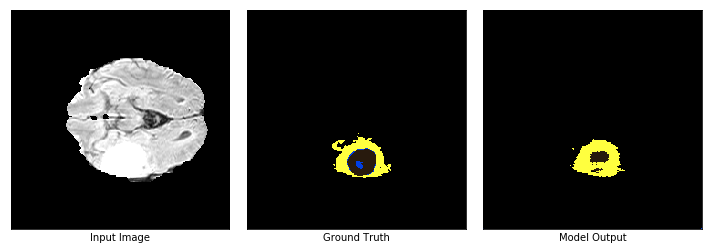

Steps: 2000, Loss:0.029673995450139046
Accurary: 0.984409749507904
Dice coefficient: [0.9134227, 0.92123634, 1.0]
Sensitivity: [0.9074988805113752, 0.9125699797233237, 1.0]
Specificity: [0.9999652777792245, 0.9997472275347156, 1.0]
Gradient min:-0.011552692390978336, max:0.012422800064086914

Epochs  2



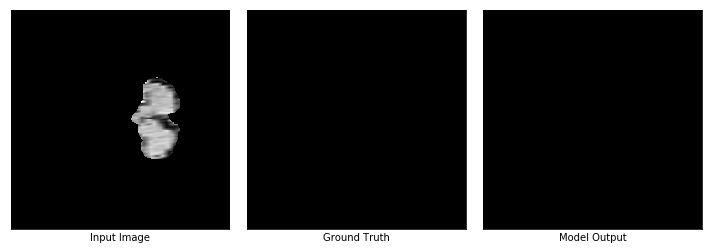

Steps: 2000, Loss:0.01877562887966633
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.003478609025478363, max:0.0021318471990525723

Epochs  3



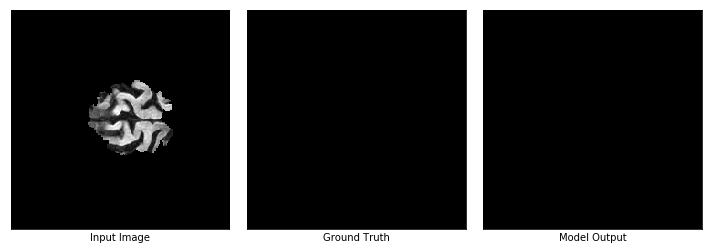

Steps: 2000, Loss:0.008440245874226093
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.00626482255756855, max:0.005874654743820429

Epochs  4



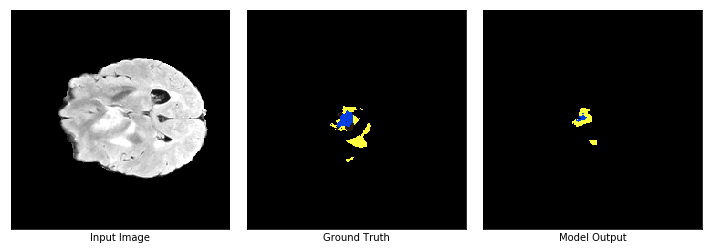

Steps: 2000, Loss:0.018509559333324432
Accurary: 0.9891666769981384
Dice coefficient: [0.92072374, 0.9291669, 1.0]
Sensitivity: [0.915585444995054, 0.9291669146839622, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.009328784421086311, max:0.009889782406389713

Epochs  5



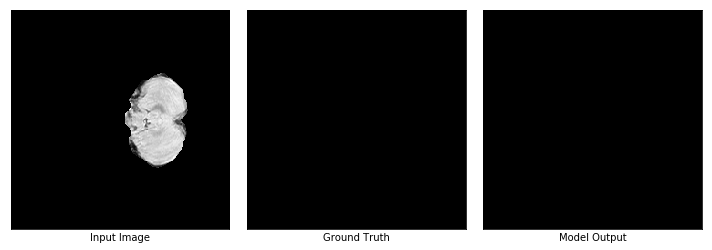

Steps: 2000, Loss:0.008055591024458408
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.002447359962388873, max:0.002107233041897416

-----------<Summary for Epoch:5>------------
Mean Accuracy: 0.9904696345329285
Mean Dice coefficient: [0.83590573 0.8276231  1.        ]
Mean Sensitivity: [0.89708356 0.89576997 1.        ]
Mean Specificity: [0.99941826 0.99927991 1.        ]
------------------------------------------------


Epochs  6



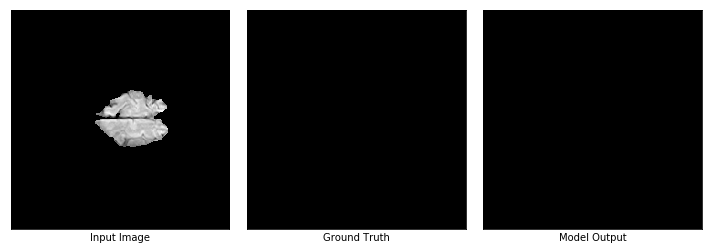

Steps: 2000, Loss:0.01174343004822731
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.003961544018238783, max:0.004745068494230509

Epochs  7



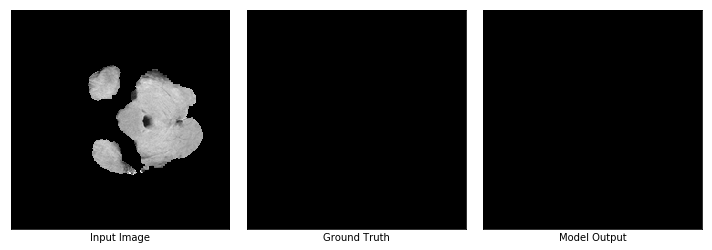

Steps: 2000, Loss:0.009073005057871342
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.0022099867928773165, max:0.0025991874281316996

Epochs  8



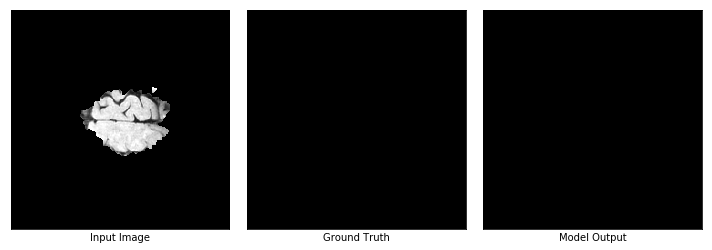

Steps: 2000, Loss:0.009522577747702599
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.0032995776273310184, max:0.005622236058115959

Epochs  9



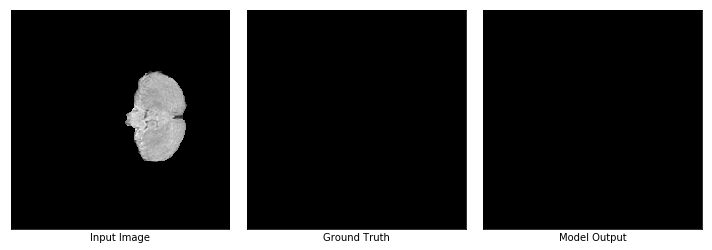

Steps: 2000, Loss:0.005155945662409067
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.0026541873812675476, max:0.001970841083675623

Epochs 10



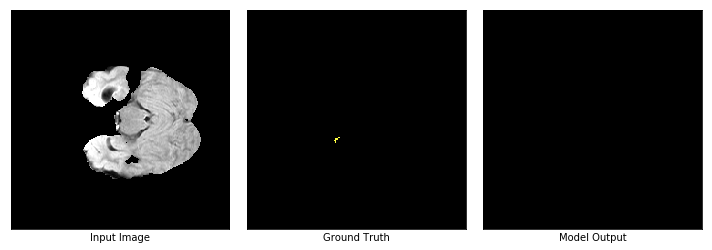

Steps: 2000, Loss:0.018145350739359856
Accurary: 0.9996528029441833
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.005009796936064959, max:0.004699524492025375

-----------<Summary for Epoch:10>------------
Mean Accuracy: 0.9935163259506226
Mean Dice coefficient: [0.8739799 0.859731  1.       ]
Mean Sensitivity: [0.92029084 0.91553424 1.        ]
Mean Specificity: [0.99956687 0.99939702 1.        ]
------------------------------------------------


Epochs 11



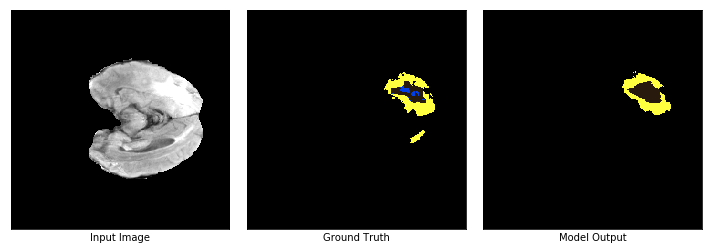

Steps: 2000, Loss:0.015091879293322563
Accurary: 0.9915451407432556
Dice coefficient: [0.9826156, 0.97527117, 1.0]
Sensitivity: [0.9893791698411519, 0.9891466140340588, 1.0]
Specificity: [0.9985766438022601, 0.9968811683610448, 1.0]
Gradient min:-0.005693810526281595, max:0.005684432573616505

Epochs 12



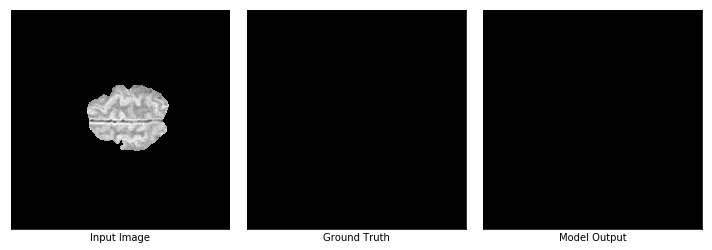

Steps: 2000, Loss:0.006493061315268278
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.0016085724346339703, max:0.0012881237780675292

Epochs 13



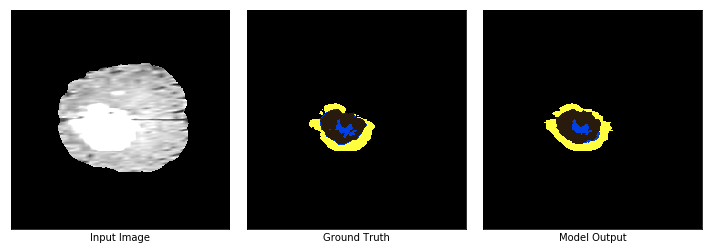

Steps: 2000, Loss:0.008450852707028389
Accurary: 0.9915798902511597
Dice coefficient: [0.9853597, 0.9860477, 1.0]
Sensitivity: [0.9888125558234836, 0.9930572216711409, 1.0]
Specificity: [0.9982293104737993, 0.997608186005147, 1.0]
Gradient min:-0.004261531867086887, max:0.005646901670843363

Epochs 14



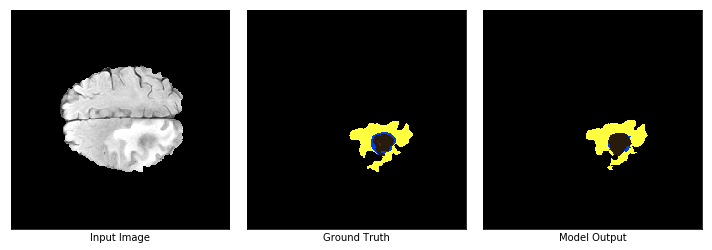

Steps: 2000, Loss:0.008964302949607372
Accurary: 0.9935243129730225
Dice coefficient: [0.9886537, 0.982723, 1.0]
Sensitivity: [0.9860749624582261, 0.9986805583449008, 1.0]
Specificity: [0.99965886240353, 0.99839661519522, 1.0]
Gradient min:-0.006140044890344143, max:0.005665905307978392

Epochs 15



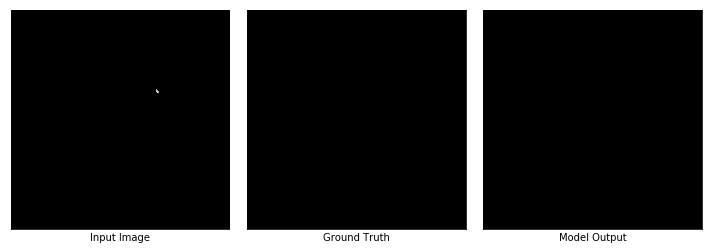

Steps: 2000, Loss:0.00572629040107131
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.0020818952471017838, max:0.001193469506688416

-----------<Summary for Epoch:15>------------
Mean Accuracy: 0.9947274327278137
Mean Dice coefficient: [0.89412665 0.87806255 1.        ]
Mean Sensitivity: [0.93072313 0.92481467 1.        ]
Mean Specificity: [0.99964491 0.99947053 1.        ]
------------------------------------------------


Epochs 16



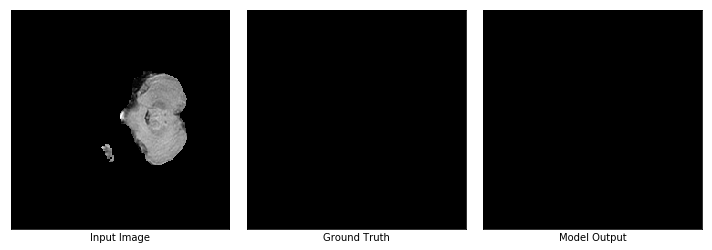

Steps: 2000, Loss:0.009830350987613201
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.0035884033422917128, max:0.004799926187843084

Epochs 17



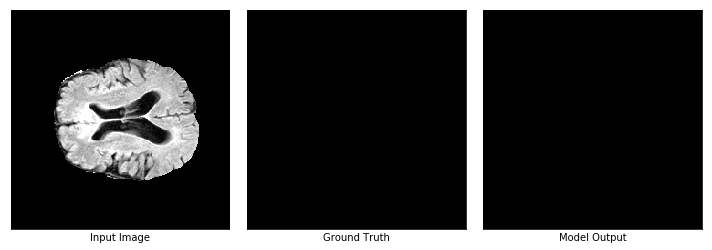

Steps: 2000, Loss:0.006008385214954615
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.004046499263495207, max:0.0035223003942519426

Epochs 18



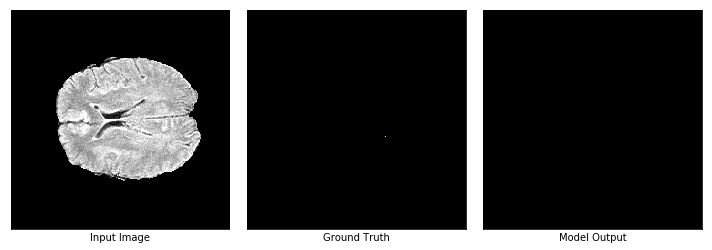

Steps: 2000, Loss:0.008204043842852116
Accurary: 0.9999826550483704
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.0023082601837813854, max:0.0021963021717965603

Epochs 19



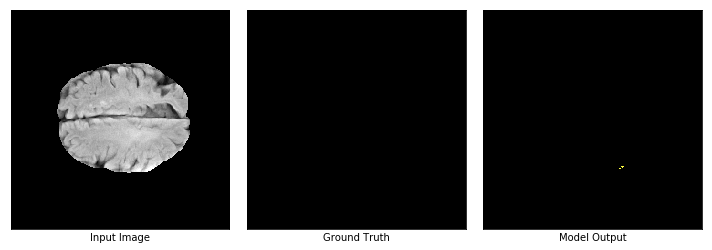

Steps: 2000, Loss:0.0075768157839775085
Accurary: 0.999878466129303
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.002622540108859539, max:0.002327968366444111

Epochs 20



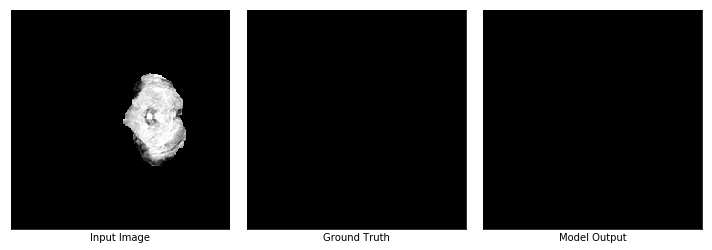

Steps: 2000, Loss:0.0034163850359618664
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.000859496823977679, max:0.000975289789494127

-----------<Summary for Epoch:20>------------
Mean Accuracy: 0.9954200983047485
Mean Dice coefficient: [0.90773416 0.890809   1.        ]
Mean Sensitivity: [0.93671658 0.93072988 1.        ]
Mean Specificity: [0.99969358 0.9995229  1.        ]
------------------------------------------------


Epochs 21



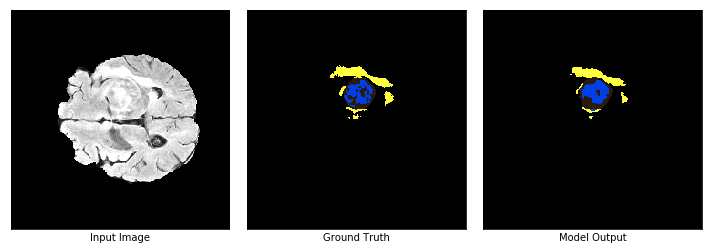

Steps: 2000, Loss:0.006503005977720022
Accurary: 0.9909027814865112
Dice coefficient: [0.9829918, 0.95990837, 1.0]
Sensitivity: [0.9973088121892988, 0.9653859352484733, 1.0]
Specificity: [0.9986831926081121, 0.9979443260901595, 1.0]
Gradient min:-0.005900541786104441, max:0.007257556542754173

Epochs 22



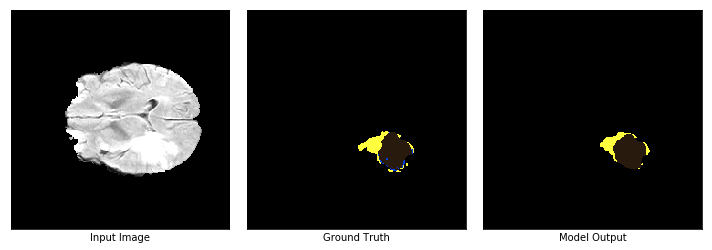

Steps: 2000, Loss:0.009655631147325039
Accurary: 0.9948784708976746
Dice coefficient: [0.97198576, 0.97516024, 1.0]
Sensitivity: [0.9692752602701075, 0.9759675284655107, 1.0]
Specificity: [0.999034453206474, 0.9986398342565447, 1.0]
Gradient min:-0.005070931743830442, max:0.004548671189695597

Epochs 23



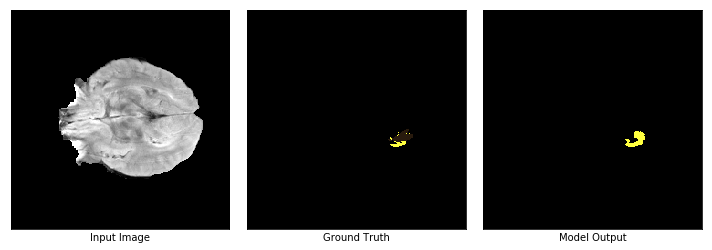

Steps: 2000, Loss:0.008068586699664593
Accurary: 0.9959375262260437
Dice coefficient: [0.93750006, 0.93750006, 1.0]
Sensitivity: [0.9375000749304316, 0.9375000749304316, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.0063315266743302345, max:0.005441477056592703

Epochs 24



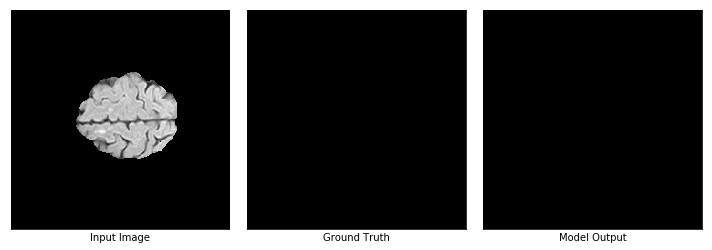

Steps: 2000, Loss:0.007877630181610584
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.0020976613741368055, max:0.0023674520198255777

Epochs 25



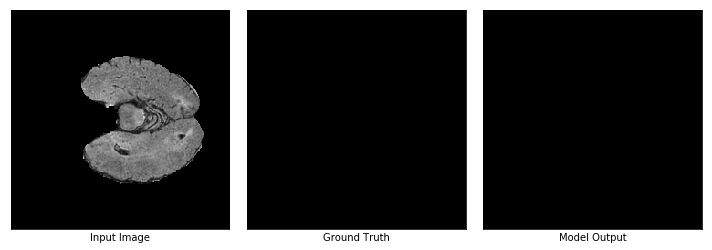

Steps: 2000, Loss:0.00809680949896574
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.00866498053073883, max:0.006611259188503027

-----------<Summary for Epoch:25>------------
Mean Accuracy: 0.9958845973014832
Mean Dice coefficient: [0.9177862 0.9006164 1.       ]
Mean Sensitivity: [0.94144892 0.93516893 1.        ]
Mean Specificity: [0.99972397 0.99956203 1.        ]
------------------------------------------------


Epochs 26



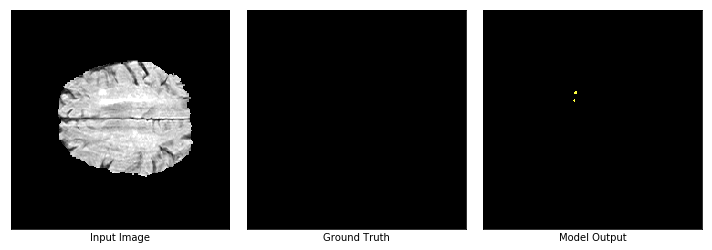

Steps: 2000, Loss:0.003658569883555174
Accurary: 0.99979168176651
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.0011137445690110326, max:0.001364644500426948

Epochs 27



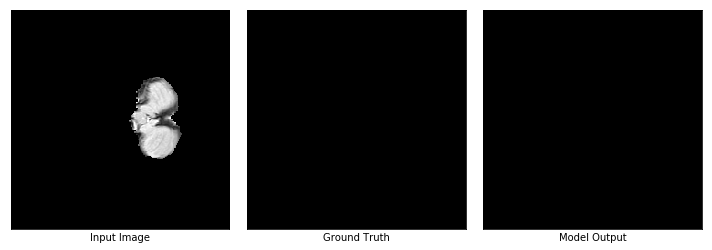

Steps: 2000, Loss:0.001669426099397242
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.0003662405943032354, max:0.0003903920587617904

Epochs 28



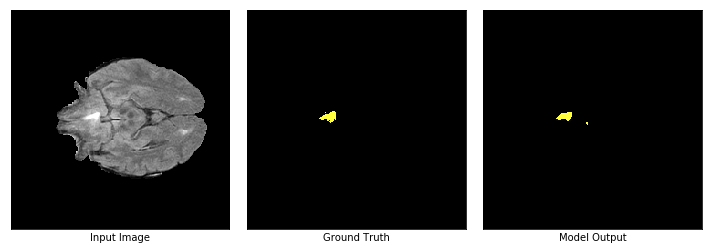

Steps: 2000, Loss:0.006251039449125528
Accurary: 0.9992882013320923
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.003681481583043933, max:0.0026704382617026567

Epochs 29



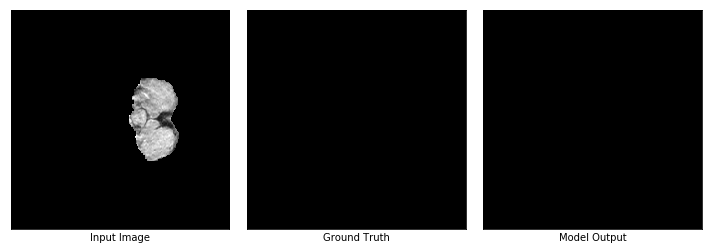

Steps: 2000, Loss:0.001265031984075904
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.0006113016861490905, max:0.000562017725314945

Epochs 30



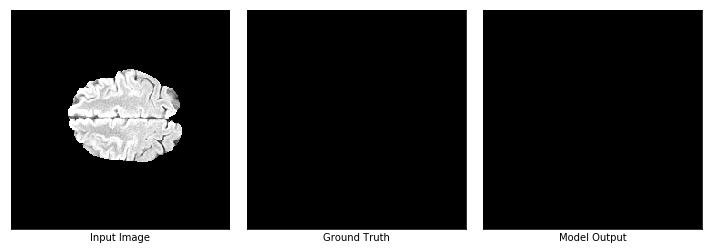

Steps: 2000, Loss:0.004123079124838114
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.0010552266612648964, max:0.0016245534643530846

-----------<Summary for Epoch:30>------------
Mean Accuracy: 0.9962247014045715
Mean Dice coefficient: [0.9258866  0.90889096 1.        ]
Mean Sensitivity: [0.9452497  0.93882962 1.        ]
Mean Specificity: [0.99974718 0.99959315 1.        ]
------------------------------------------------



In [7]:
epochs = 1
max_epochs = 30
#list
loss_list = []
acc_list = []
loss_inner = []
while epochs <= max_epochs:
    print()
    print("Epochs {:2d}".format(epochs))
    steps = 1
    dc_app = []
    sens_app = []
    spec_app = []
    for tf_re in sorted(os.listdir(tfrecords_read_dir)):
        tf_dir = os.path.join(tfrecords_read_dir+tf_re)
        dataset = utils.parse_tfrecord(tf_dir).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE)
        acc_inner = []
        for imgs in dataset:
            image = imgs[:,:,:,:4]
            #unprocessed label for plotting 
            label = imgs[:,:,:,-1]
            #for simplicity label 4 will be converted to 3 for sparse encoding
            label = tf.where(label==4,3,label)
            label = tf.keras.utils.to_categorical(label, num_classes=4)
            img_seg, loss, gradients = train_fn(image, label) #training function 
            #map from sparse to label
            img_seg = tf.math.argmax(img_seg,-1,output_type=tf.int32) 
            label = tf.math.argmax(label,-1,output_type=tf.int32)
            #accuracy of the output values for that batch
            acc = tf.reduce_mean(tf.cast(tf.equal(img_seg,label), tf.float32))
            #append accuracy for every steps
            acc_inner.append(acc)
            if epochs%5==0:
                dc_list, sens_list, spec_list =compute_metric(label,img_seg)
                dc_app.append(dc_list)
                sens_app.append(sens_list)
                spec_app.append(spec_list)
            #output
            if steps%2000==0:
                input_img = [image[0,:,:,0], plot_labels_color(label[0]), plot_labels_color(img_seg[0])]
                caption = ['Input Image', 'Ground Truth', 'Model Output']
                plot_comparison(input_img, caption, n_col = 3, figsize=(10,10))
                loss_list.append(loss)
                acc_stp = tf.reduce_mean(tf.cast(tf.equal(img_seg[0],label[0]), tf.float32))
                dc_list_stp, sens_list_stp, spec_list_stp =compute_metric(label[0],img_seg[0])
                print("Steps: {}, Loss:{}".format(steps, loss))
                print("Accurary: {}".format(acc_stp))
                print("Dice coefficient: {}".format(dc_list_stp))
                print("Sensitivity: {}".format(sens_list_stp))
                print("Specificity: {}".format(spec_list_stp))
                print("Gradient min:{}, max:{}".format(np.min(gradients[0]), np.max(gradients[0])))
            steps+=1
        acc_list.append(np.mean(acc_inner))
    if epochs%5==0:
        mean_dc = np.mean(np.array(dc_app),0)
        mean_sens = np.mean(np.array(sens_app),0)
        mean_spec = np.mean(np.array(spec_app),0)
        print()
        print('-----------<Summary for Epoch:{}>------------'.format(epochs))
        print("Mean Accuracy: {}".format(np.mean(acc_list)))
        print("Mean Dice coefficient: {}".format(mean_dc))
        print("Mean Sensitivity: {}".format(mean_sens))
        print("Mean Specificity: {}".format(mean_spec))
        print('------------------------------------------------')
        print()
    epochs+=1 

---

# Save Weights

In [8]:
Unet.save_weights('/home/kevinteng/Desktop/model_weights/Unet_{}.h5'.format(ver))

---

# Validation 

In [7]:
def val_fn(image, label):
    Unet.load_weights('/home/kevinteng/Desktop/model_weights/Unet_{}.h5'.format(ver))
    Unet.trainable = False
    model_output = Unet(image)
    loss = xent(label, model_output)
    return model_output, loss

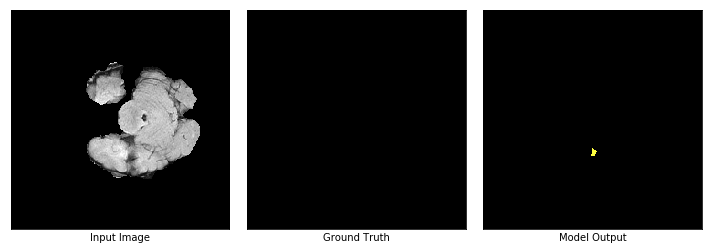

Steps: 100, Loss:0.01781185157597065
Accuracy: 0.9993923902511597
Dice coefficient: [1.0, 1.0, 0.9625]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 0.9993923611364294]



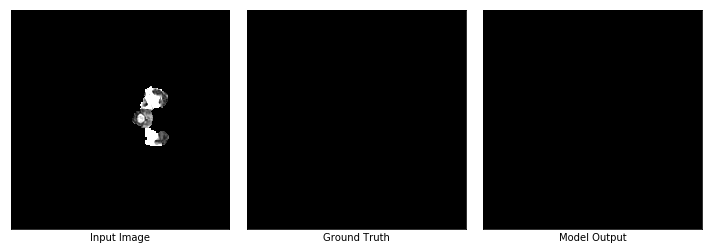

Steps: 200, Loss:0.05292917415499687
Accuracy: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]



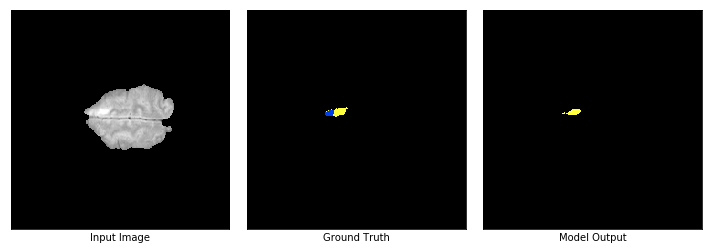

Steps: 300, Loss:0.026077866554260254
Accuracy: 0.9983506798744202
Dice coefficient: [0.975, 1.0, 0.975701530277729]
Sensitivity: [0.9750000347056373, 1.0, 0.9715591537383423]
Specificity: [1.0, 1.0, 1.0]
Mean Accuracy: 0.992485523223877
Mean Dice coefficient: [0.71110755 0.76213706 0.77893979]
Mean Sensitivity: [0.75573671 0.92799232 0.84581937]
Mean Specificity: [0.99946272 0.99940599 0.99881177]



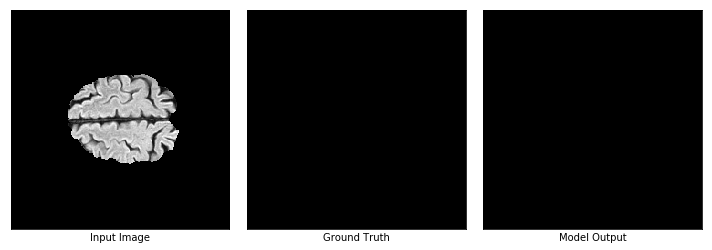

Steps: 400, Loss:0.024202296510338783
Accuracy: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]



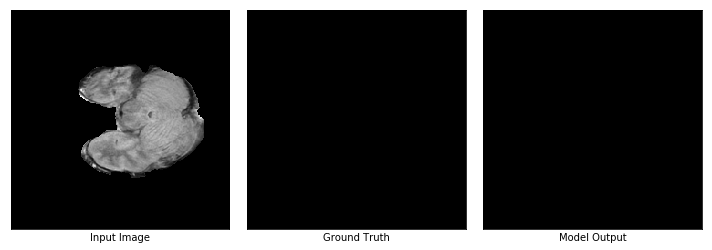

Steps: 500, Loss:0.07223976403474808
Accuracy: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]



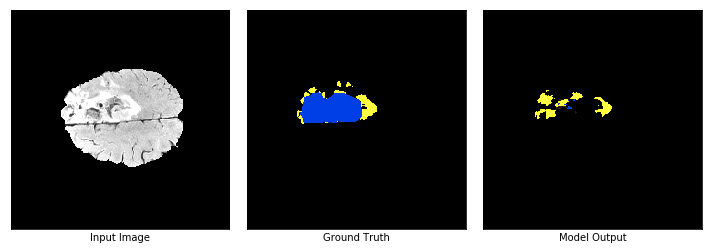

Steps: 600, Loss:0.13402004539966583
Accuracy: 0.961388885974884
Dice coefficient: [0.86613765587875, 0.9541666666666667, 0.8642157664212088]
Sensitivity: [0.8627023444033898, 1.0, 0.8449605976636373]
Specificity: [1.0, 0.9993055555844906, 0.9999210519382189]
Mean Accuracy: 0.991117537021637
Mean Dice coefficient: [0.65023987 0.75518651 0.77129955]
Mean Sensitivity: [0.67007274 0.91490448 0.79940085]
Mean Specificity: [0.99967343 0.99963812 0.99917965]


In [8]:
tfrecords_val = '/home/kevinteng/Desktop/ssd02/BraTS20_tfrecords03/LGG/'

steps = 1
acc_list = []
for tf_re in sorted(os.listdir(tfrecords_val)):
    tf_dir = os.path.join(tfrecords_val+tf_re)
    dataset = utils.parse_tfrecord(tf_dir).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE)
    dc_app = []
    sens_app = []
    spec_app = []
    for imgs in dataset:
        image = imgs[:,:,:,:4]
        label = imgs[:,:,:,-1]
        label = tf.where(label==4,3,label)
        #for simplicity label 4 will be converted to 3 for sparse encoding
        label = tf.keras.utils.to_categorical(label, num_classes=4)
        img_seg, loss = val_fn(image, label) #validation function 
        #map from sparse to label
        img_seg = tf.math.argmax(img_seg,-1,output_type=tf.int32) 
        label = tf.math.argmax(label,-1,output_type=tf.int32)
        #accuracy of the output values for that batch
        acc = tf.reduce_mean(tf.cast(tf.equal(img_seg,label), tf.float32))
        dc_list, sens_list, spec_list =compute_metric(label,img_seg)
        #append
        acc_list.append(acc)
        dc_app.append(dc_list)
        sens_app.append(sens_list)
        spec_app.append(spec_list)
        #output
        if steps%100==0:
#             dc_list, sens_list, spec_list =compute_metric(label[0],img_seg[0])
            input_img = [image[0,:,:,0], plot_labels_color(label[0]), plot_labels_color(img_seg[0])]
            caption = ['Input Image', 'Ground Truth', 'Model Output']
            plot_comparison(input_img, caption, n_col = 3, figsize=(10,10))
            acc_stp = tf.reduce_mean(tf.cast(tf.equal(img_seg[0],label[0]), tf.float32))
            dc_list, sens_list, spec_list =compute_metric(label[0],img_seg[0])
            print("Steps: {}, Loss:{}".format(steps, loss))
            print("Accuracy: {}".format(acc_stp))
            print("Dice coefficient: {}".format(dc_list))
            print("Sensitivity: {}".format(sens_list))
            print("Specificity: {}".format(spec_list))
        steps+=1
    mean_dc = np.mean(np.array(dc_app),0)
    mean_sens = np.mean(np.array(sens_app),0)
    mean_spec = np.mean(np.array(spec_app),0)
    print("Mean Accuracy: {}".format(np.mean(acc_list)))
    print("Mean Dice coefficient: {}".format(mean_dc))
    print("Mean Sensitivity: {}".format(mean_sens))
    print("Mean Specificity: {}".format(mean_spec))

---

# Model Summary

In [11]:
Unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 240, 4) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 240, 240, 64) 2368        input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 240, 240, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 240, 240, 64) 36928       activation[0][0]                 
______________________________________________________________________________________________